<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPORTS" data-toc-modified-id="IMPORTS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPORTS</a></span></li><li><span><a href="#EXPLORE" data-toc-modified-id="EXPLORE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EXPLORE</a></span></li></ul></div>

# IMPORTS

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:90% !important;}</style>'))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

In [3]:
# Display plots in the notebook
%matplotlib inline

In [4]:
def assess_df(df):
  
    # declare the feature types in the dataframe.
    # this adds dynamism to the function, whereby it can check
    # for constant columns on a dtype-amended or non-amended
    # dataframe.
    # Applicable for constant column check below

    feature_types = {df[df.columns[x]].dtypes.name for x in range(len(df.columns))}
    
  	# print datatypes
  
    print("Datatypes:\n")
    print(df.dtypes)
    print('\n\n')
    
    # print number rows and cols
    print('*' * 50)
    print('ROWS, COLUMNS, NULLS\n')
    print(df.shape[0], "rows in the dataframe.")
    print(df.shape[1], "columns in the dataframe.\n")
    print(df.isnull().sum().sum(), "null values in the dataframe.")
    
    # check duplicate rows & col; print if present
    
    duplicate_rows = df.duplicated(keep=False).sum()
    duplicate_cols = df.index.T.duplicated(keep=False).sum()
    
    print(duplicate_rows, "duplicate rows")
    print(duplicate_cols, "duplicate columns")
    
    if duplicate_rows > 0 or duplicate_cols > 0:
      print(df.loc[df.duplicated()])
	
    print('\n')
    
    
    # check for constant columns
    # form lists of numeric and categorical columns
    
    numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
    categorical_cols = list(df.select_dtypes('category').columns.values)
    
    # generate list of standard deviations for each numeric feature
    # a standard deviation of 0 indicates a constant numeric column.
    
    standard_diffs = [df.describe().loc['std', x] for x in numeric_cols]
    
    
    # for each categorical column, check whether the feature has
    # a unique value of 1. if yes, indicates a constant column
    
    constant_categorical_column=False
    if 'category' in feature_types:
        for column in categorical_cols:
            if df[column].describe().index.unique == 1:
                constant_categorical_column = True
    
    # print the results of checking for constant columns
    # for both continuous and categorical features
            
    if 0 in standard_diffs:
        print("Constant numeric columns: TRUE")
    else:
        print("Constant numeric columns: FALSE")
  
    if 'category' in feature_types:    
        if constant_categorical_column == True:
            print("Constant categorical columns: TRUE")
        else:
            print("Constant categorical columns: FALSE")

            
    
    print('\n\n')

    
    # feature stats
    print('*' * 50)
    print('DESCRIPTION\n')
    print(df.describe().T)
    print('\n\n')
    print('*' * 50)

    
    # feature stats: categorical
    
    if 'category' in feature_types:
        print('CATEGORICAL DESCRIPTION\n')
        print('\n')
        print(df.select_dtypes(['category']).describe().T)
        print('\n\n')
        print('*' * 50)
    
    # print feature cardinalities
    
    print("FEATURE CARDINALITIES\n")
    column_names = list(df.columns.values)

    print('{0:45}  {1}'.format("Feature", "Distinct Values"))
    print('{0:45}  {1}'.format("-------", "--------------- \n"))

    for c in column_names:
        print('{0:45}  {1}'.format(c, str(len(df[c].unique()))))
    
    print('\n')
    print('*' * 50)
    print('MEMORY\n')
    
    
    print(df.info(memory_usage='deep'))
    print('\n')
    print(df.memory_usage(deep=True))
    print('\n')
    print('*' * 50)
    print('HEAD\n')
    print(df.head(10))
    print('\n')
    print('*' * 50)
    print('TAIL\n')
    print(df.tail(10))

# EXPLORE

In [5]:
df = pd.read_feather('/tmp/ssh_mount/data/dataframes/230719_trips.feather')

In [6]:
df.dropna(axis=0, inplace=True)

In [7]:
# remove obvious errors whereby departure time is later than arrival time for a trip

df.drop(df[df.ACTUALTIME_DEP > df.ACTUALTIME_ARR].index, inplace=True)

In [8]:
df.shape

(1893264, 13)

In [9]:
# remove low range outliers, based on trip duration
# (trips under 45min)

df.drop(df[df.ACTUAL_TRIP_DURATION < 2750].index, inplace=True)

In [10]:
df.shape

(1442964, 13)

In [10]:
df.head()

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,ACTUAL_TRIP_DURATION,DAYOFWEEK,MONTH,HOURRANGE_DEPARTURE
0,2018-02-07,6253783,68,68_80,1,87245,84600,87524.0,84600.0,2924.0,2,2,23:00-00:00
2,2018-02-07,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,4247.0,2,2,08:00-09:00
3,2018-02-07,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,4020.0,2,2,15:00-16:00
4,2018-02-07,6253175,14,14_15,1,85383,81600,84682.0,81608.0,3074.0,2,2,22:00-23:00
5,2018-02-07,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,4481.0,2,2,10:00-11:00


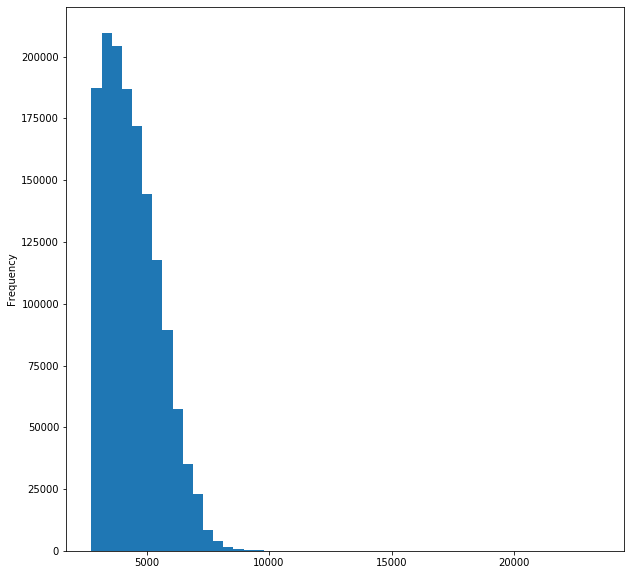

In [11]:
# hist plot trip durations

df.ACTUAL_TRIP_DURATION.plot(kind='hist', figsize=(10,10), bins=50)

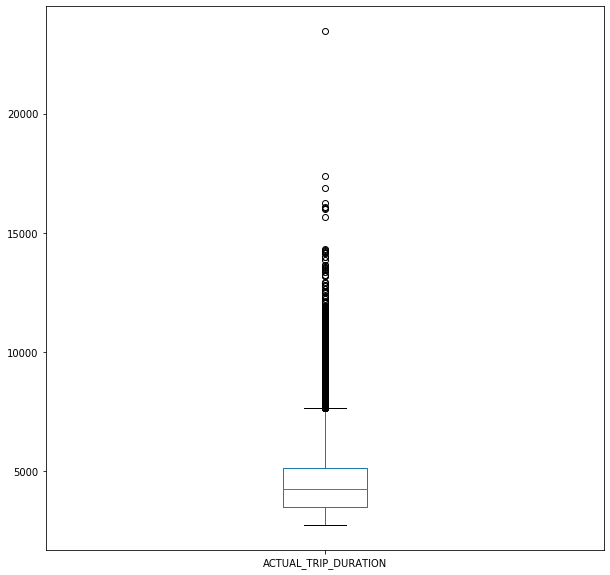

In [12]:
# box plot journey durations

df.ACTUAL_TRIP_DURATION.plot(kind='box', figsize=(10,10))

<br>

Z-Scores for Outlier Detection

<br>

In [19]:
# check zscores for route 14

zscore_14 = np.abs(stats.zscore(df.loc[df.LINEID == '14','ACTUAL_TRIP_DURATION']))

In [20]:
zscore_14

array([2.1842437 , 0.08045119, 1.5824031 , ..., 0.14878766, 0.8330996 ,
       1.4601167 ], dtype=float32)

In [43]:
# inspect zscore outliers for route 14
# returns row numbers

outliers = np.where(zscore_14 > 3)

len(outliers[0])

240

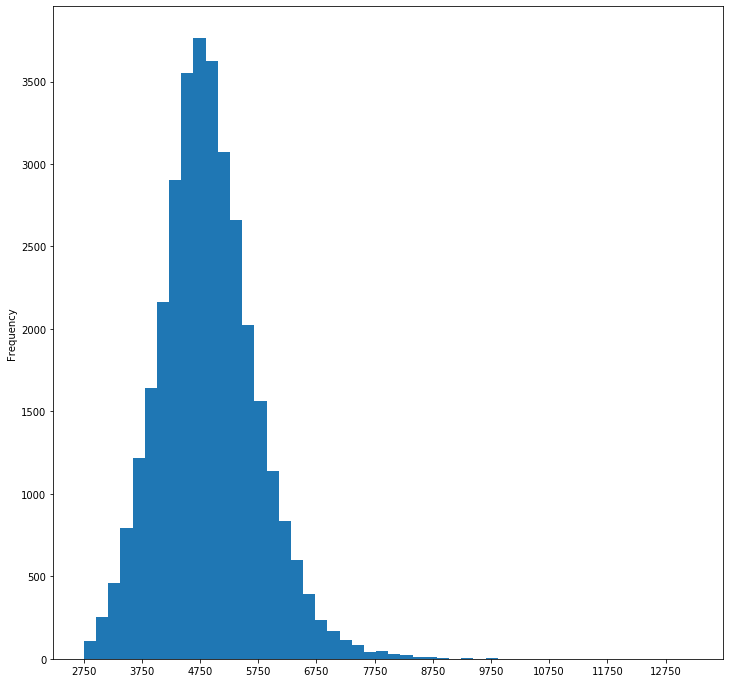

In [29]:
plt.xticks(np.arange(min(df.ACTUAL_TRIP_DURATION), max(df.ACTUAL_TRIP_DURATION)+1, 1000))
df.loc[df.LINEID == '14', 'ACTUAL_TRIP_DURATION'].plot(kind='hist', figsize=(12,12), bins=50)

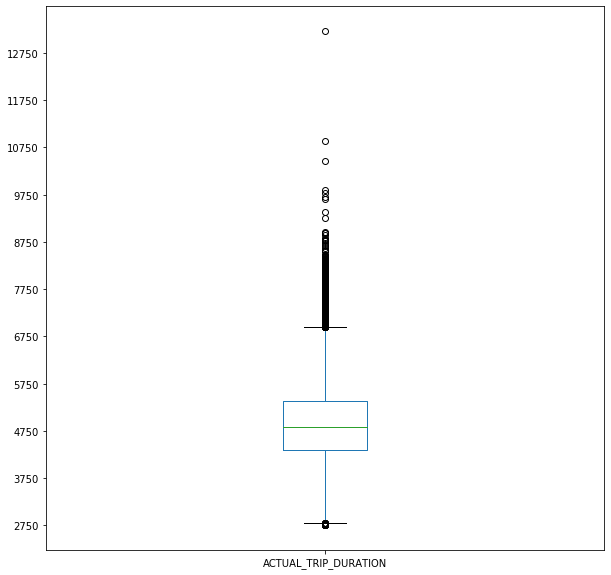

In [30]:
plt.yticks(np.arange(min(df.ACTUAL_TRIP_DURATION), max(df.ACTUAL_TRIP_DURATION)+1, 1000))
df.loc[df.LINEID == '14']['ACTUAL_TRIP_DURATION'].plot(kind='box', figsize=(10,10))

In [50]:
outliers = np.where(zscore_14 > 3)

len(outliers[0])

240

In [60]:
outliers[0][-1]

33543

In [63]:
df.iloc[33543, 9]

4248.0

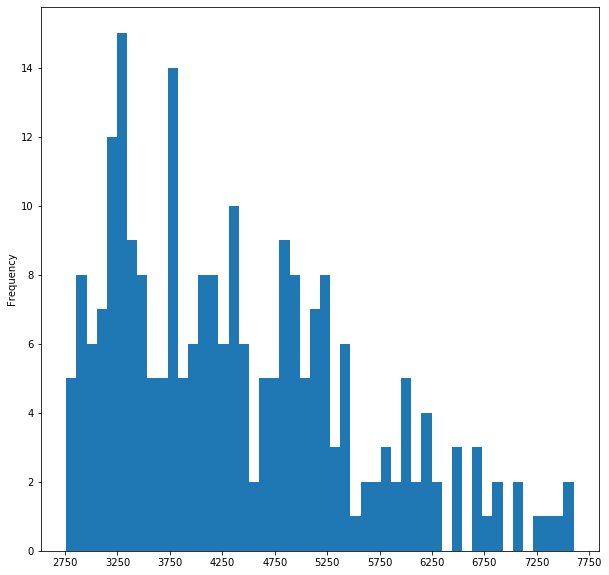

In [59]:
plt.xticks(np.arange(min(df.ACTUAL_TRIP_DURATION), max(df.ACTUAL_TRIP_DURATION)+1, 500))
df.iloc[outliers[0]]['ACTUAL_TRIP_DURATION'].plot(kind='hist', figsize=(10,10), bins=50)

<br>

Checking Max and Median Journey Time for Each Route

<br>

In [75]:
lines = df.LINEID.unique().tolist()

for line in lines:
    zscore = np.abs(stats.zscore(df.loc[df.LINEID == line,'ACTUAL_TRIP_DURATION']))
    outliers = np.where(zscore > 3.5)
    num_outliers = len(outliers[0])
#     num_rows = len(df.loc[df.LINEID == line])
    
    
    print(line, "MEDIAN: ", df.loc[df.LINEID == line, 'ACTUAL_TRIP_DURATION'].median())
    print(line, "MAX :", df.loc[df.LINEID == line, 'ACTUAL_TRIP_DURATION'].max())
    print(line, "NUM OUTLIERS: ", num_outliers)
    print("\n")

68 MEDIAN:  4121.0
68 MAX : 10100.0
68 NUM OUTLIERS:  33


45A MEDIAN:  3684.0
45A MAX : 6952.0
45A NUM OUTLIERS:  24


25A MEDIAN:  3454.0
25A MAX : 12041.0
25A NUM OUTLIERS:  180


14 MEDIAN:  4841.0
14 MAX : 13215.0
14 NUM OUTLIERS:  126


77A MEDIAN:  4774.0
77A MAX : 14153.0
77A NUM OUTLIERS:  56


39 MEDIAN:  5078.0
39 MAX : 12815.0
39 NUM OUTLIERS:  44


16 MEDIAN:  5558.0
16 MAX : 12888.0
16 NUM OUTLIERS:  35


40D MEDIAN:  3127.0
40D MAX : 10651.0
40D NUM OUTLIERS:  85


27B MEDIAN:  3159.0
27B MAX : 6543.0
27B NUM OUTLIERS:  114


83 MEDIAN:  4747.0
83 MAX : 11430.0
83 NUM OUTLIERS:  38


15 MEDIAN:  5400.0
15 MAX : 12957.0
15 NUM OUTLIERS:  28


46A MEDIAN:  4489.0
46A MAX : 14325.0
46A NUM OUTLIERS:  53


33 MEDIAN:  5527.0
33 MAX : 11737.0
33 NUM OUTLIERS:  88


7 MEDIAN:  4483.0
7 MAX : 11861.0
7 NUM OUTLIERS:  71


39A MEDIAN:  5216.0
39A MAX : 10935.0
39A NUM OUTLIERS:  116


1 MEDIAN:  3266.0
1 MAX : 23458.0
1 NUM OUTLIERS:  135


41 MEDIAN:  3685.0
41 MAX : 13579.0
41